# Comparison of Bayesian Inference: Analytical Approach vs MCMC with PyMC

This notebook compares two approaches for solving Bayesian inference problems:
1. Analytical approach using conjugate distributions
2. MCMC approach using PyMC

We will see how both methods can be used to solve the same problem and analyze their differences, advantages, and disadvantages.

## Importing necessary libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymc as pm
import arviz as az
import pandas as pd
import seaborn as sns

# Configuration for plots
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 14

# Configuration for reproducibility
np.random.seed(42)

## Problem: Estimating the success rate in a binomial process

Let's consider a classic problem in Bayesian inference: estimating the probability of success $\theta$ in a binomial process (for example, the probability of a coin landing heads).

### Problem Context

Imagine we have a coin that might be biased. We want to estimate the probability $\theta$ that the coin lands heads. To do this, we conduct an experiment by flipping the coin several times and recording the results.

In this case, we'll use simulated data for our example:

In [3]:
# True parameter (unknown in a real case)
theta_true = 0.7

# Number of flips
n_trials = 50

# Generate simulated data (1 = heads, 0 = tails)
data = np.random.binomial(1, theta_true, size=n_trials)

# Number of successes (heads)
n_success = np.sum(data)

print(f"Number of flips: {n_trials}")
print(f"Number of heads: {n_success}")
print(f"Proportion of heads: {n_success/n_trials:.4f}")

Number of flips: 50
Number of heads: 39
Proportion of heads: 0.7800


## 1. Analytical Approach: Conjugate Distributions

In Bayesian inference, when the prior distribution and likelihood have mathematical forms that allow a closed-form solution for the posterior distribution, we talk about conjugate distributions.

For the case of a binomial distribution, the natural conjugate prior is the Beta distribution. If we use a Beta distribution as a prior, the posterior will also be a Beta distribution.

### Prior Distribution

We'll use a Beta distribution as a prior for $\theta$:

$$\theta \sim \text{Beta}(\alpha, \beta)$$

where $\alpha$ and $\beta$ are the parameters of the Beta distribution. For this example, we'll use $\alpha = 1$ and $\beta = 1$, which corresponds to a uniform distribution on $[0, 1]$, representing that we have no prior information about the bias of the coin.

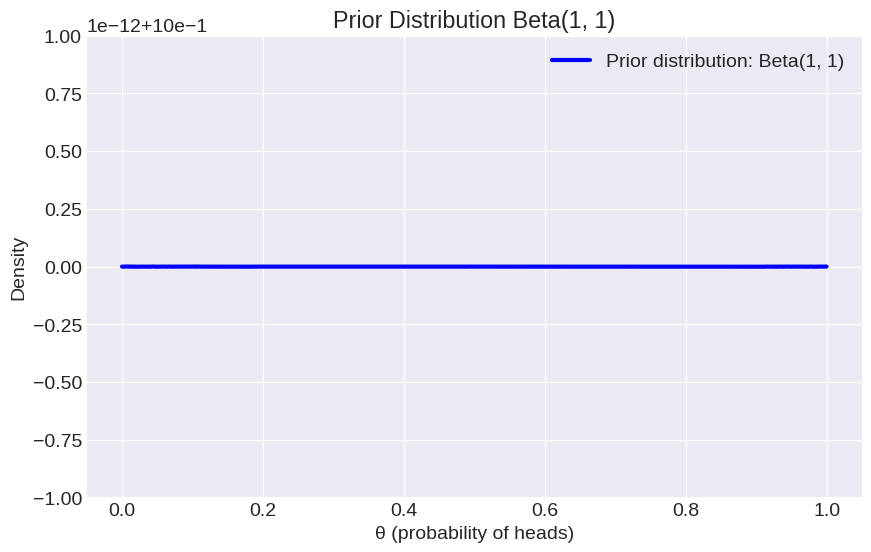

In [4]:
# Parameters of the prior distribution
alpha_prior = 1
beta_prior = 1

# Visualize the prior distribution
theta_values = np.linspace(0, 1, 1000)
prior_pdf = stats.beta.pdf(theta_values, alpha_prior, beta_prior)

plt.figure(figsize=(10, 6))
plt.plot(theta_values, prior_pdf, 'b-', lw=3, label='Prior distribution: Beta(1, 1)')
plt.xlabel('θ (probability of heads)')
plt.ylabel('Density')
plt.title('Prior Distribution Beta(1, 1)')
plt.legend()
plt.grid(True)
plt.show()

### Likelihood

The likelihood for a binomial process with $n$ trials and $k$ successes is:

$$P(\text{data}|\theta) = \binom{n}{k} \theta^k (1-\theta)^{n-k}$$

Let's visualize this likelihood function for our data:

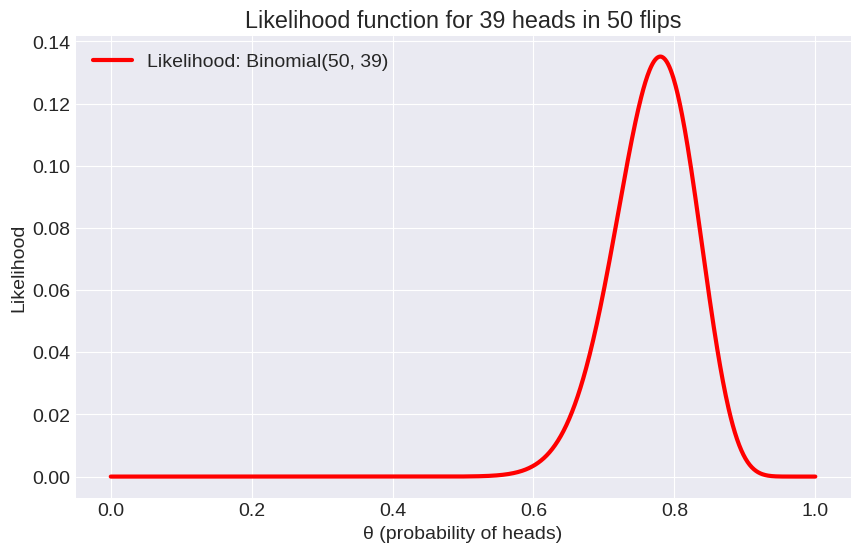

In [5]:
# Likelihood function
def likelihood(theta, n, k):
    return stats.binom.pmf(k, n, theta)

# Visualize the likelihood
likelihood_values = [likelihood(theta, n_trials, n_success) for theta in theta_values]

plt.figure(figsize=(10, 6))
plt.plot(theta_values, likelihood_values, 'r-', lw=3, label=f'Likelihood: Binomial({n_trials}, {n_success})')
plt.xlabel('θ (probability of heads)')
plt.ylabel('Likelihood')
plt.title(f'Likelihood function for {n_success} heads in {n_trials} flips')
plt.legend()
plt.grid(True)
plt.show()

### Analytical Posterior Distribution

For a Beta($\alpha$, $\beta$) prior distribution and a binomial likelihood with $n$ trials and $k$ successes, the posterior distribution is Beta($\alpha + k$, $\beta + n - k$).

In our case, the posterior distribution will be:

Posterior distribution: Beta(40, 12)


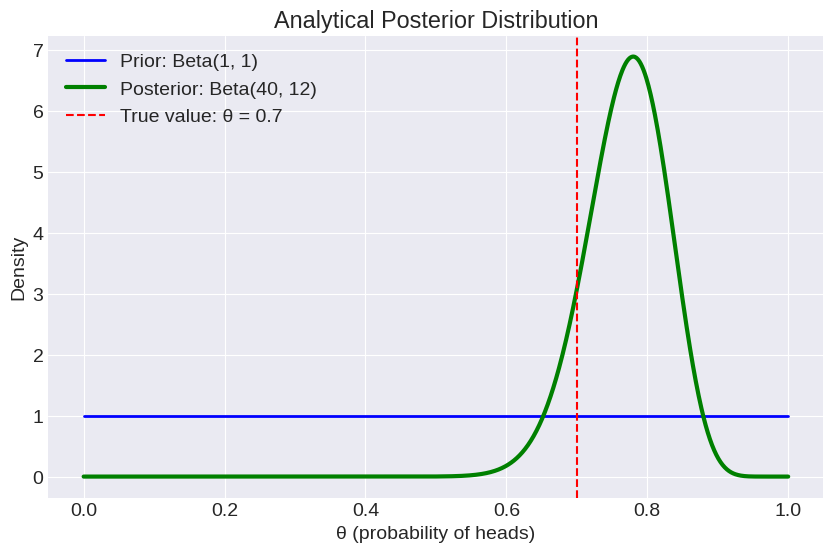

In [6]:
# Parameters of the posterior distribution
alpha_posterior = alpha_prior + n_success
beta_posterior = beta_prior + n_trials - n_success

print(f"Posterior distribution: Beta({alpha_posterior}, {beta_posterior})")

# Visualize the posterior distribution
posterior_pdf = stats.beta.pdf(theta_values, alpha_posterior, beta_posterior)

plt.figure(figsize=(10, 6))
plt.plot(theta_values, prior_pdf, 'b-', lw=2, label='Prior: Beta(1, 1)')
plt.plot(theta_values, posterior_pdf, 'g-', lw=3, label=f'Posterior: Beta({alpha_posterior}, {beta_posterior})')
plt.axvline(x=theta_true, color='r', linestyle='--', label=f'True value: θ = {theta_true}')
plt.xlabel('θ (probability of heads)')
plt.ylabel('Density')
plt.title('Analytical Posterior Distribution')
plt.legend()
plt.grid(True)
plt.show()

### Statistics of the Posterior Distribution

Let's calculate some statistics of interest from the posterior distribution:

In [7]:
# Posterior mean
posterior_mean = alpha_posterior / (alpha_posterior + beta_posterior)
print(f"Posterior mean: {posterior_mean:.4f}")

# Posterior mode
posterior_mode = (alpha_posterior - 1) / (alpha_posterior + beta_posterior - 2) if alpha_posterior > 1 and beta_posterior > 1 else "N/A"
print(f"Posterior mode: {posterior_mode:.4f}")

# 95% credible interval
ci_lower, ci_upper = stats.beta.interval(0.95, alpha_posterior, beta_posterior)
print(f"95% credible interval: [{ci_lower:.4f}, {ci_upper:.4f}]")

Posterior mean: 0.7692
Posterior mode: 0.7800
95% credible interval: [0.6468, 0.8721]


### Complete Visualization of the Analytical Approach

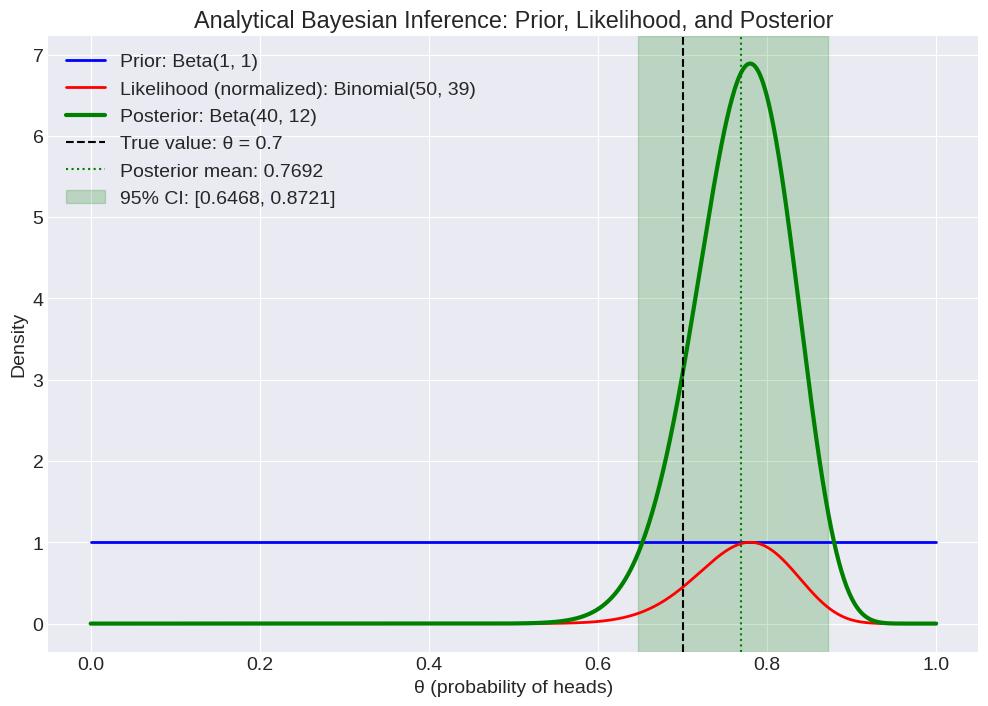

In [8]:
plt.figure(figsize=(12, 8))
plt.plot(theta_values, prior_pdf, 'b-', lw=2, label='Prior: Beta(1, 1)')
plt.plot(theta_values, likelihood_values / max(likelihood_values), 'r-', lw=2, 
         label=f'Likelihood (normalized): Binomial({n_trials}, {n_success})')
plt.plot(theta_values, posterior_pdf, 'g-', lw=3, label=f'Posterior: Beta({alpha_posterior}, {beta_posterior})')
plt.axvline(x=theta_true, color='k', linestyle='--', label=f'True value: θ = {theta_true}')
plt.axvline(x=posterior_mean, color='g', linestyle=':', label=f'Posterior mean: {posterior_mean:.4f}')
plt.axvspan(ci_lower, ci_upper, alpha=0.2, color='g', label=f'95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]')
plt.xlabel('θ (probability of heads)')
plt.ylabel('Density')
plt.title('Analytical Bayesian Inference: Prior, Likelihood, and Posterior')
plt.legend()
plt.grid(True)
plt.show()

## 2. MCMC Approach with PyMC

Now we'll solve the same problem using Markov Chain Monte Carlo (MCMC) methods implemented in PyMC. Although for this simple problem it's not necessary to use MCMC (since we have an analytical solution), this approach allows us to illustrate how MCMC methods work and how they are used in practice.

### Model Definition in PyMC

In [9]:
# Define the Bayesian model in PyMC
with pm.Model() as binomial_model:
    # Prior
    theta = pm.Beta('theta', alpha=alpha_prior, beta=beta_prior)
    
    # Likelihood
    y = pm.Binomial('y', n=n_trials, p=theta, observed=n_success)
    
    # Sampling
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

# Summary of results
summary = az.summary(trace)
summary

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


/home/enrique/anaconda3/envs/bayesian/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.768,0.058,0.655,0.871,0.001,0.001,3467.0,5151.0,1.0


### Visualization of MCMC Results

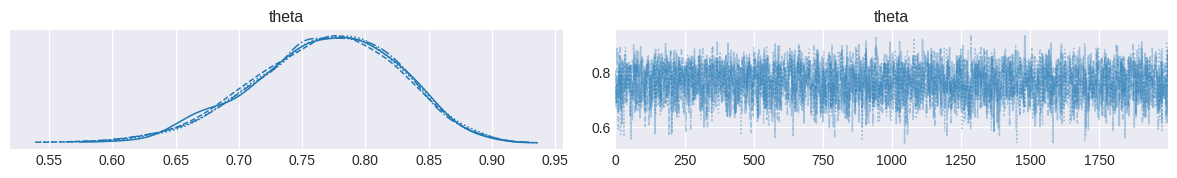

In [10]:
# MCMC chain trace
az.plot_trace(trace)
plt.tight_layout()
plt.show()

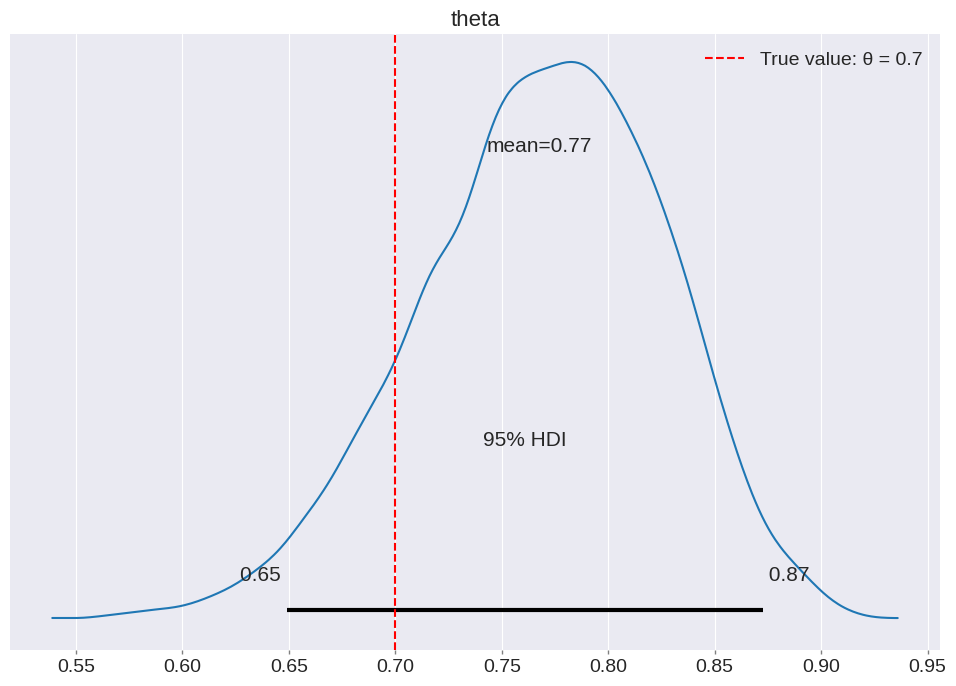

In [11]:
# Posterior distribution of theta
az.plot_posterior(trace, hdi_prob=0.95)
plt.axvline(x=theta_true, color='r', linestyle='--', label=f'True value: θ = {theta_true}')
plt.legend()
plt.show()

### Comparison of MCMC Posterior with Analytical Posterior

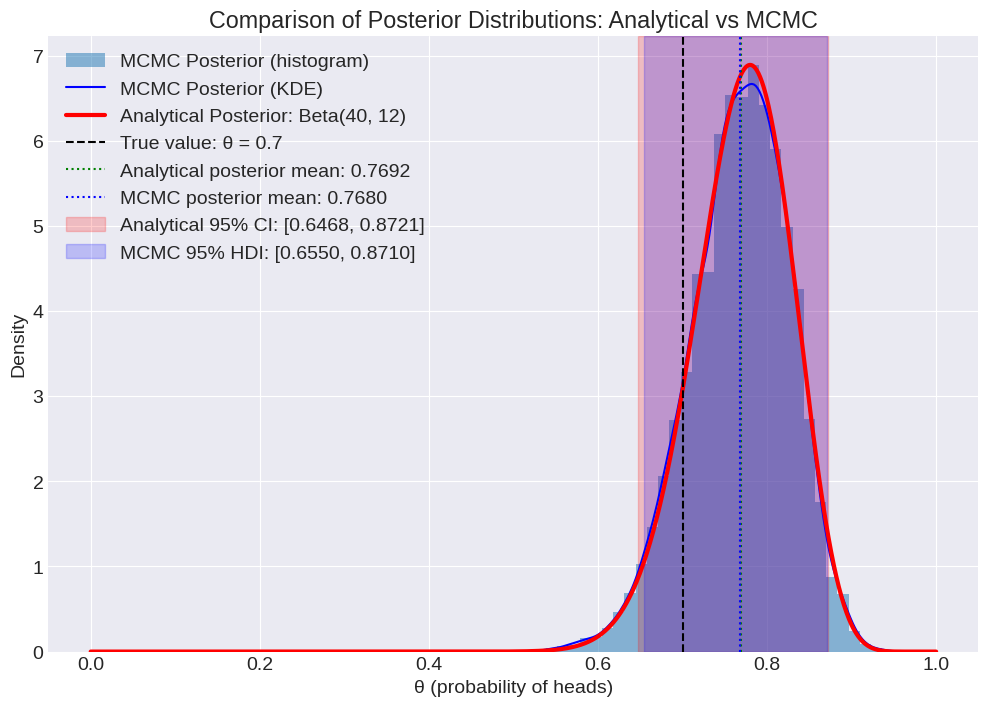

In [12]:
# Extract theta samples
theta_samples = trace.posterior['theta'].values.flatten()

# Compare posterior distributions
plt.figure(figsize=(12, 8))

# Histogram of MCMC samples
plt.hist(theta_samples, bins=30, density=True, alpha=0.5, label='MCMC Posterior (histogram)')

# KDE density of MCMC samples
sns.kdeplot(theta_samples, label='MCMC Posterior (KDE)', color='blue')

# Analytical posterior distribution
plt.plot(theta_values, posterior_pdf, 'r-', lw=3, label=f'Analytical Posterior: Beta({alpha_posterior}, {beta_posterior})')

# True value and posterior mean
plt.axvline(x=theta_true, color='k', linestyle='--', label=f'True value: θ = {theta_true}')
plt.axvline(x=posterior_mean, color='g', linestyle=':', label=f'Analytical posterior mean: {posterior_mean:.4f}')
plt.axvline(x=summary.loc['theta', 'mean'], color='b', linestyle=':', label=f'MCMC posterior mean: {summary.loc["theta", "mean"]:.4f}')

# Analytical credible interval
plt.axvspan(ci_lower, ci_upper, alpha=0.2, color='r', label=f'Analytical 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]')

# MCMC HDI interval
hdi_lower = summary.loc['theta', 'hdi_3%']
hdi_upper = summary.loc['theta', 'hdi_97%']
plt.axvspan(hdi_lower, hdi_upper, alpha=0.2, color='b', label=f'MCMC 95% HDI: [{hdi_lower:.4f}, {hdi_upper:.4f}]')

plt.xlabel('θ (probability of heads)')
plt.ylabel('Density')
plt.title('Comparison of Posterior Distributions: Analytical vs MCMC')
plt.legend()
plt.grid(True)
plt.show()

## 3. MCMC Diagnostics

One advantage of MCMC methods is that they provide diagnostic tools to evaluate the convergence and quality of the samples.

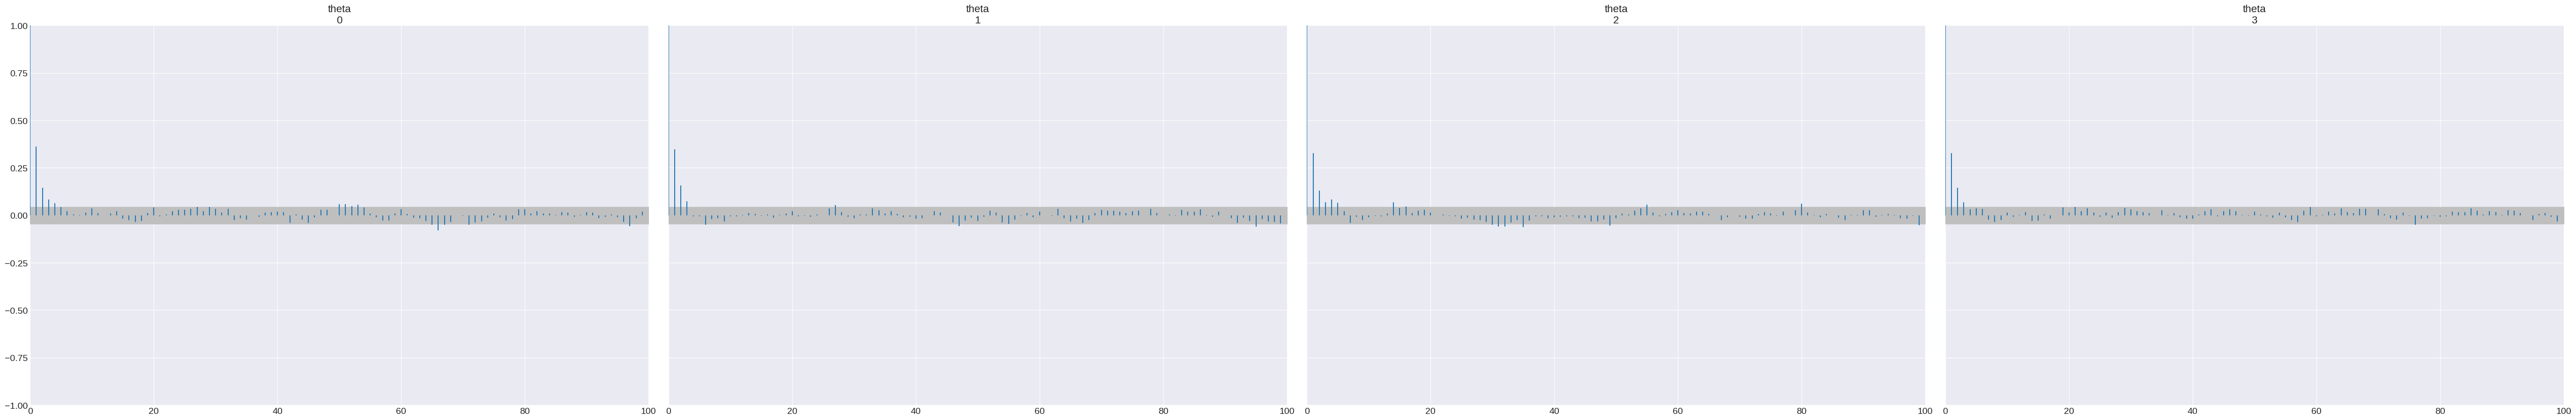

In [13]:
# Autocorrelation plot
az.plot_autocorr(trace)
plt.tight_layout()
plt.show()

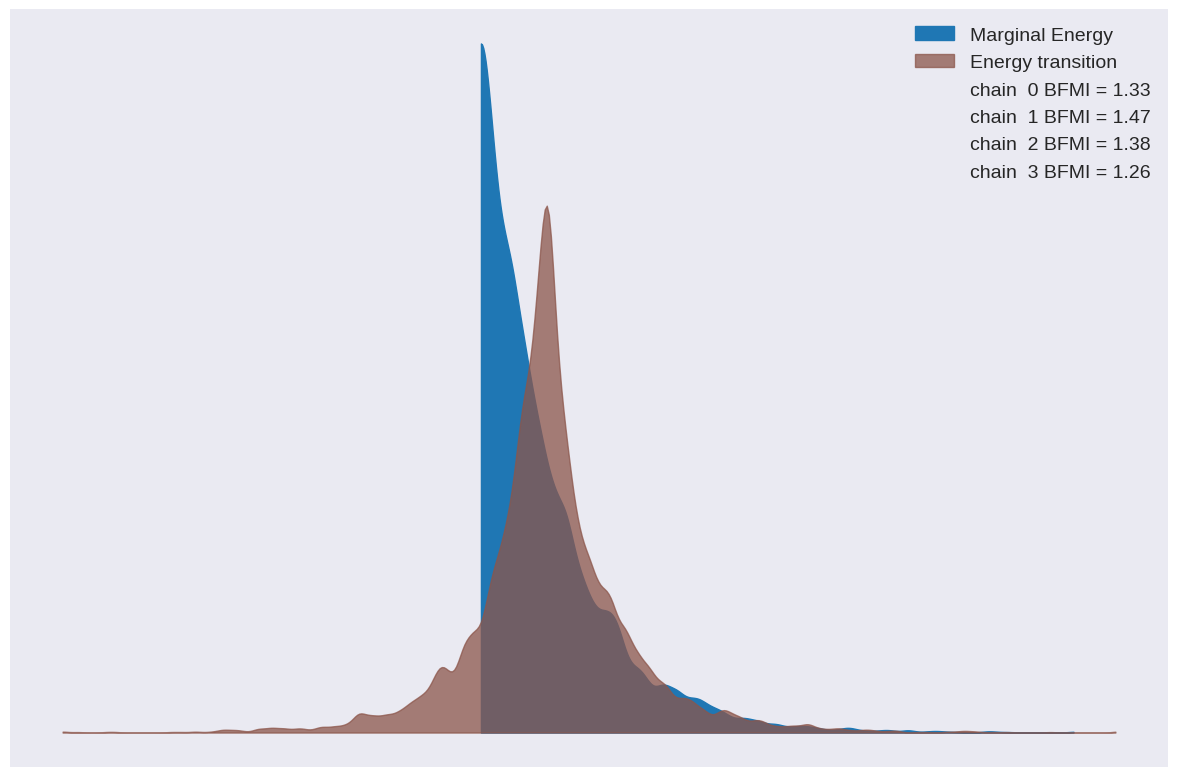

In [14]:
# Energy plot
az.plot_energy(trace)
plt.tight_layout()
plt.show()

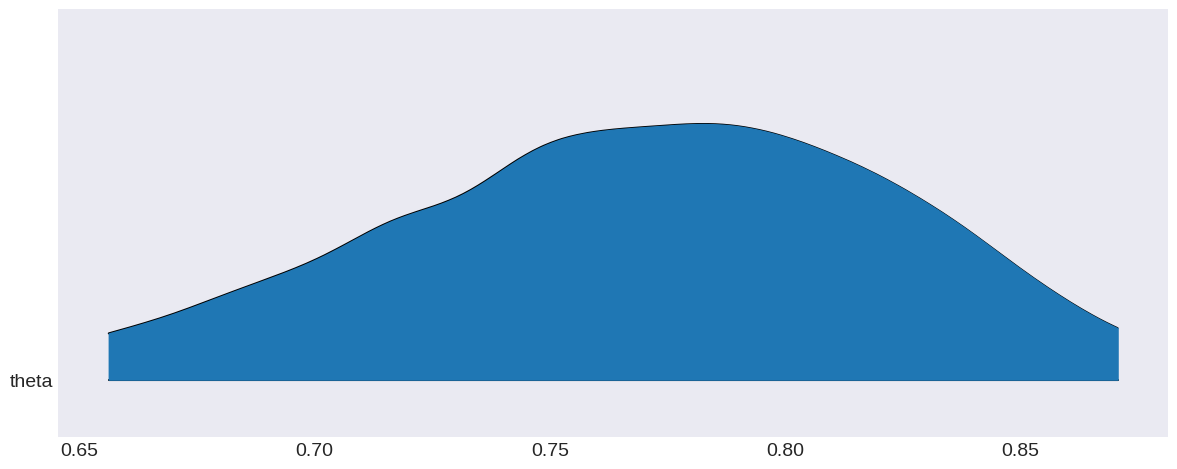

In [15]:
# Diagnostic statistics
az.plot_forest(trace, var_names=['theta'], combined=True, kind='ridgeplot')
plt.tight_layout()
plt.show()

## 4. Comparison of Approaches: Analytical vs MCMC

Now that we've solved the same problem using two different approaches, we can compare their results and characteristics.

In [16]:
# Create a DataFrame to compare the results
comparison_df = pd.DataFrame({
    'Method': ['Analytical', 'MCMC'],
    'Mean': [posterior_mean, summary.loc['theta', 'mean']],
    'Standard deviation': [stats.beta.std(alpha_posterior, beta_posterior), summary.loc['theta', 'sd']],
    'Lower interval': [ci_lower, hdi_lower],
    'Upper interval': [ci_upper, hdi_upper]
})

comparison_df

,Method,Mean,Standard deviation,Lower interval,Upper interval
0,Analytical,0.769231,0.057873,0.646786,0.872092
1,MCMC,0.768000,0.058000,0.655000,0.871000


### Key Differences Between Approaches

#### Analytical Approach
- **Advantages**:
  - Exact and deterministic solution
  - Computationally efficient
  - No convergence diagnostics required
- **Disadvantages**:
  - Only applicable to certain models with conjugate distributions
  - Limited to relatively simple models
  - Difficult to extend to complex hierarchical models

#### MCMC Approach
- **Advantages**:
  - Applicable to almost any Bayesian model
  - Can handle complex and high-dimensional models
  - Provides direct samples from the posterior distribution
  - Facilitates the calculation of any posterior statistic of interest
- **Disadvantages**:
  - Stochastic approximation (not exact)
  - Computationally more intensive
  - Requires convergence diagnostics
  - May suffer from mixing and convergence problems in complex models

## 5. More Complex Example: Bayesian Linear Regression

To better illustrate the advantages of MCMC, let's look at a slightly more complex example: Bayesian linear regression. In this case, the analytical solution is possible but more complicated, while the MCMC approach remains relatively simple to implement.

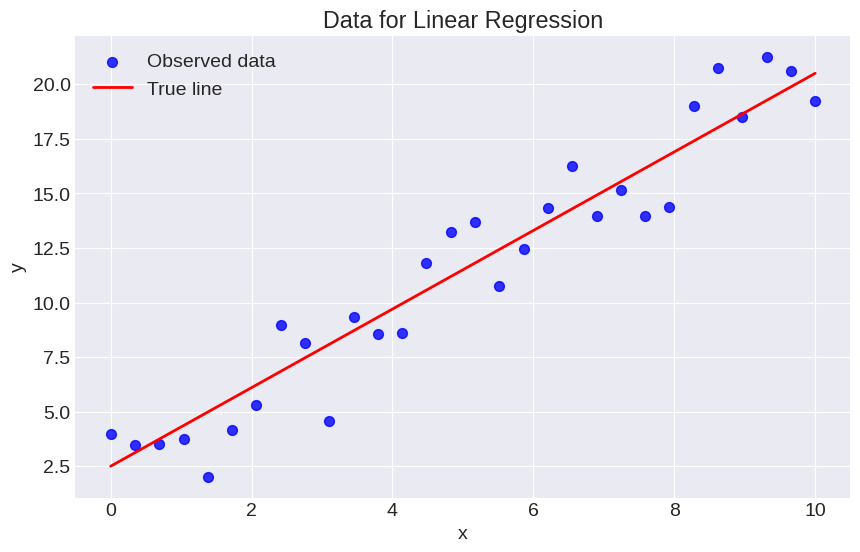

In [18]:
# Generate data for linear regression
n_points = 30
x = np.linspace(0, 10, n_points)
true_intercept = 2.5
true_slope = 1.8
true_sigma = 2.0

# y = intercept + slope * x + error
y = true_intercept + true_slope * x + np.random.normal(0, true_sigma, size=n_points)

# Visualize the data
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', s=50, alpha=0.8, label='Observed data')
plt.plot(x, true_intercept + true_slope * x, 'r-', lw=2, label='True line')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data for Linear Regression')
plt.legend()
plt.grid(True)
plt.show()

### Bayesian Linear Regression with PyMC

In [19]:
# Bayesian linear regression model with PyMC
with pm.Model() as linear_model:
    # Priors
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    slope = pm.Normal('slope', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=10)
    
    # Expected value of the distribution
    mu = intercept + slope * x
    
    # Likelihood
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y)
    
    # Sampling
    trace_lm = pm.sample(2000, tune=1000, return_inferencedata=True)

# Summary of results
summary_lm = az.summary(trace_lm)
summary_lm

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma]


/home/enrique/anaconda3/envs/bayesian/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,2.080,0.627,0.974,3.313,0.012,0.010,2963.0,3514.0,1.0
slope,1.875,0.107,1.669,2.077,0.002,0.002,2975.0,3448.0,1.0
sigma,1.743,0.245,1.313,2.197,0.004,0.003,4052.0,4286.0,1.0


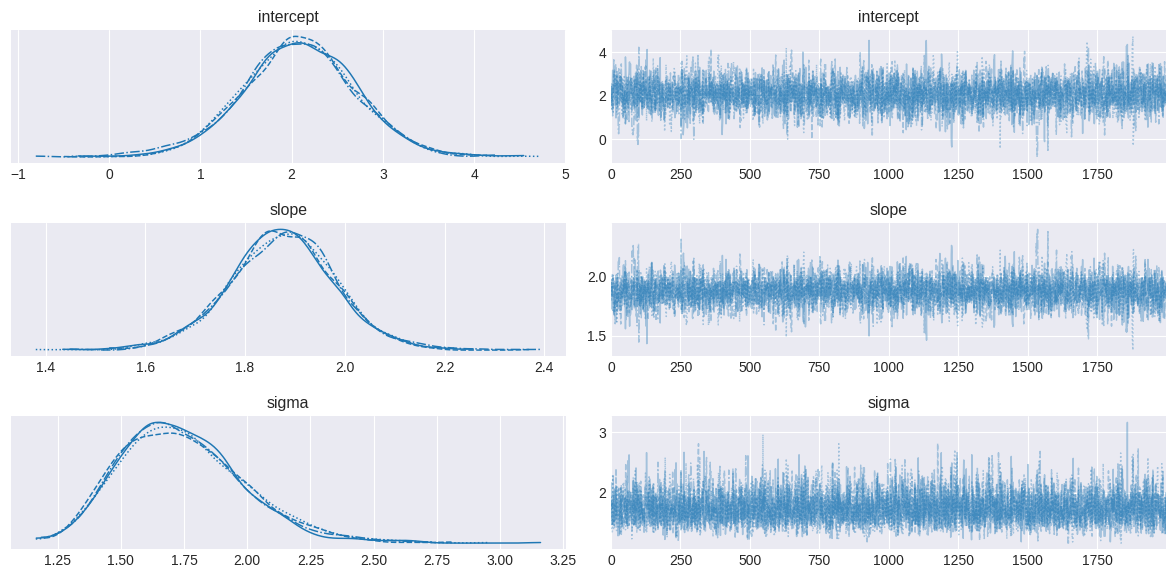

In [20]:
# Visualize the traces
az.plot_trace(trace_lm)
plt.tight_layout()
plt.show()

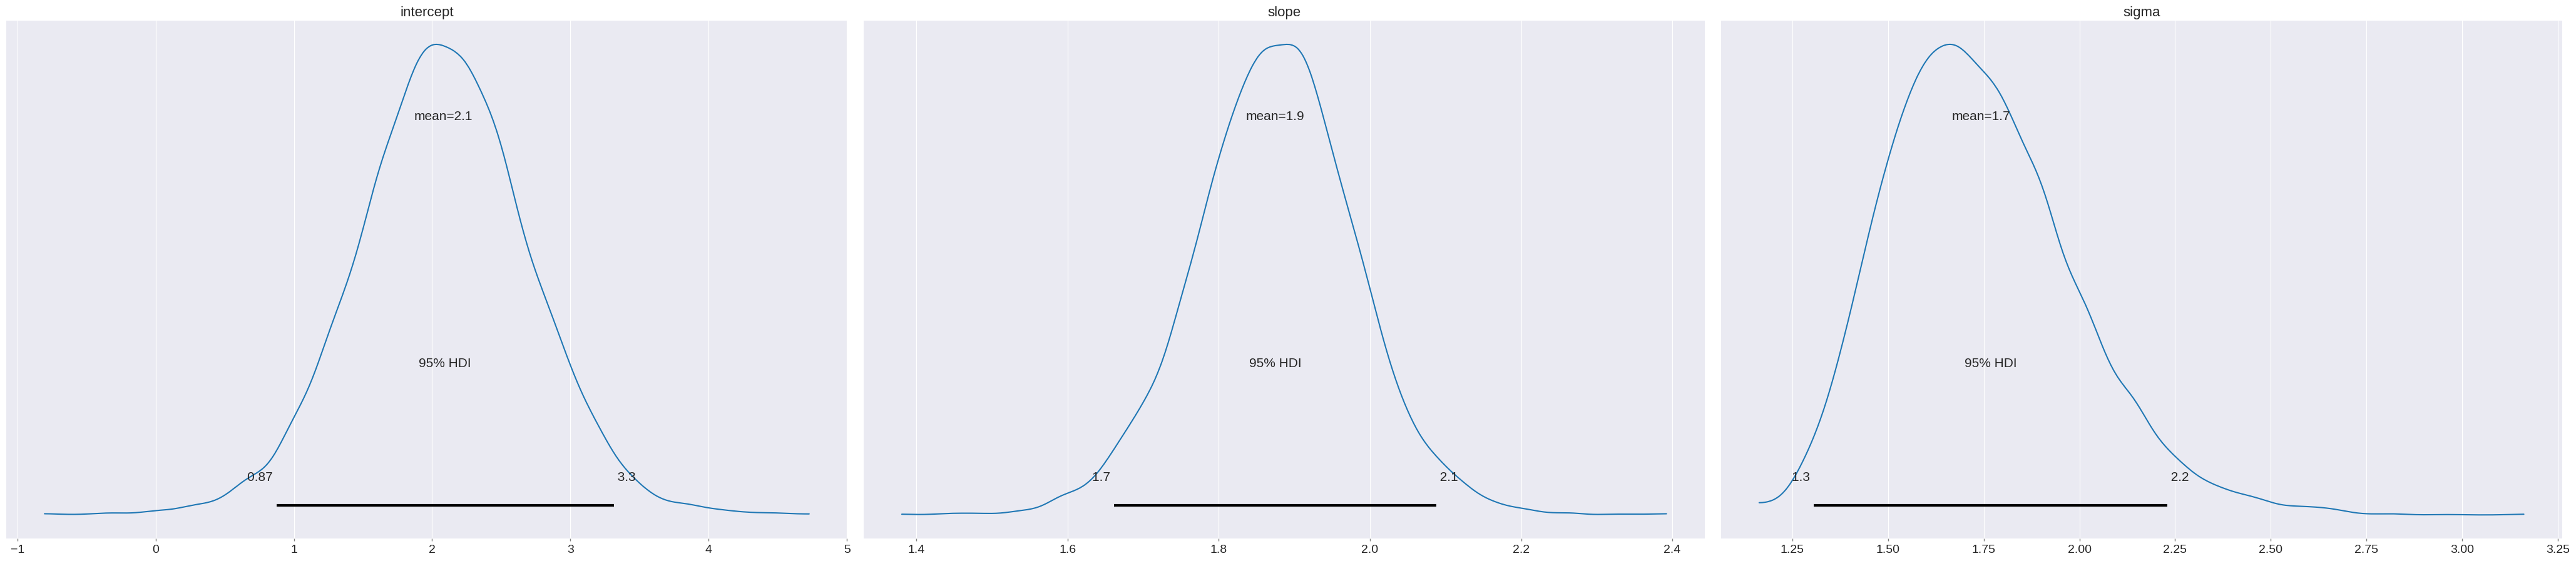

In [21]:
# Visualize the posterior distributions
az.plot_posterior(trace_lm, var_names=['intercept', 'slope', 'sigma'], hdi_prob=0.95)
plt.tight_layout()
plt.show()

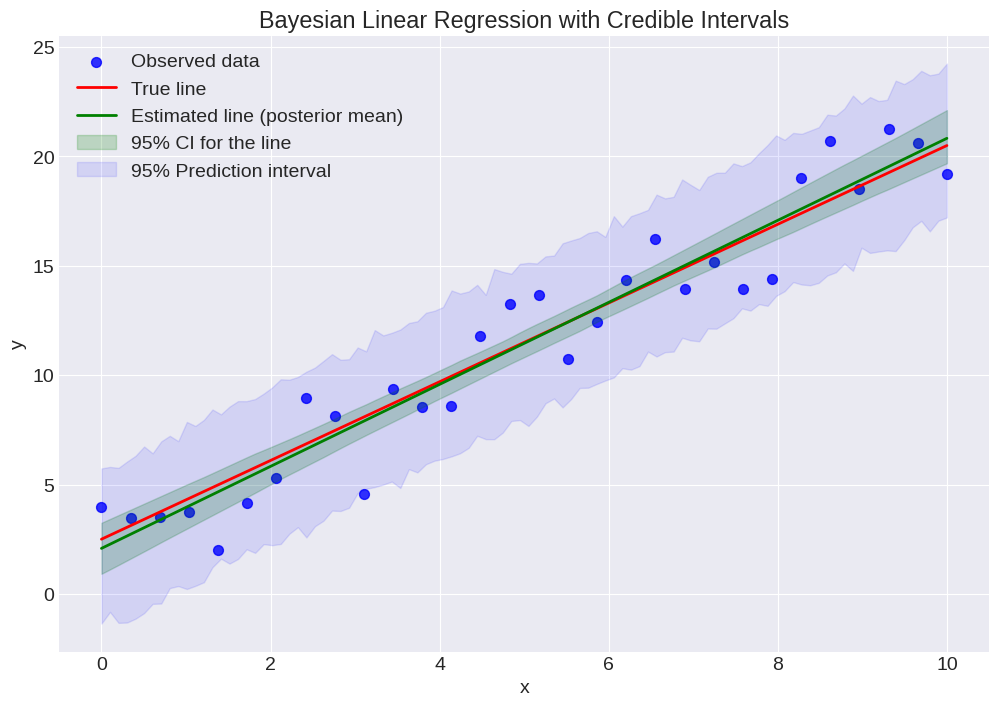

In [22]:
# Extract posterior samples
intercept_samples = trace_lm.posterior['intercept'].values.flatten()
slope_samples = trace_lm.posterior['slope'].values.flatten()
sigma_samples = trace_lm.posterior['sigma'].values.flatten()

# Visualize the regression with credible intervals
plt.figure(figsize=(12, 8))

# Original data
plt.scatter(x, y, color='blue', s=50, alpha=0.8, label='Observed data')

# True line
plt.plot(x, true_intercept + true_slope * x, 'r-', lw=2, label='True line')

# Estimated line (posterior mean)
intercept_mean = summary_lm.loc['intercept', 'mean']
slope_mean = summary_lm.loc['slope', 'mean']
plt.plot(x, intercept_mean + slope_mean * x, 'g-', lw=2, label='Estimated line (posterior mean)')

# Credible interval for the line
x_pred = np.linspace(0, 10, 100)
y_pred_samples = np.array([intercept + slope * x_pred for intercept, slope in zip(intercept_samples[:500], slope_samples[:500])])
y_pred_mean = y_pred_samples.mean(axis=0)
y_pred_lower = np.percentile(y_pred_samples, 2.5, axis=0)
y_pred_upper = np.percentile(y_pred_samples, 97.5, axis=0)

plt.fill_between(x_pred, y_pred_lower, y_pred_upper, color='g', alpha=0.2, label='95% CI for the line')

# Prediction interval (includes sigma uncertainty)
y_pred_samples_with_noise = np.array([intercept + slope * x_pred + np.random.normal(0, sigma, size=len(x_pred)) 
                                     for intercept, slope, sigma in zip(intercept_samples[:500], slope_samples[:500], sigma_samples[:500])])
y_pred_lower_with_noise = np.percentile(y_pred_samples_with_noise, 2.5, axis=0)
y_pred_upper_with_noise = np.percentile(y_pred_samples_with_noise, 97.5, axis=0)

plt.fill_between(x_pred, y_pred_lower_with_noise, y_pred_upper_with_noise, color='b', alpha=0.1, label='95% Prediction interval')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Bayesian Linear Regression with Credible Intervals')
plt.legend()
plt.grid(True)
plt.show()

## 6. Conclusions

In this notebook, we've compared two approaches for Bayesian inference:

1. **Analytical approach with conjugate distributions**:
   - Provides exact and efficient solutions
   - Limited to certain models with conjugate distributions
   - Ideal for simple and well-defined problems

2. **MCMC approach with PyMC**:
   - Provides numerical approximations through samples
   - Applicable to a wide range of complex models
   - Requires convergence diagnostics
   - Ideal for complex problems where analytical solutions are not feasible

For simple problems like estimating the probability in a binomial process, both approaches produce very similar results. However, as models become more complex, the MCMC approach becomes increasingly valuable, as illustrated in the Bayesian linear regression example.

In practice, it's important to know both approaches and choose the most appropriate one based on the complexity of the problem, the availability of conjugate distributions, and computational requirements.